In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D

In [2]:
fname = '/mnt/data/merfish/MERFISH_S2R1_cortex_For_Daniel.csv'


In [3]:
df = pd.read_csv(fname)
df

,Unnamed: 0,x,y,cell_cluster
0,1.491647e+38,638.564040,-4594.216444,4
1,2.158431e+38,593.803439,-4516.240442,4
2,2.302489e+38,597.313439,-4566.676444,4
3,2.371553e+38,613.243439,-4609.498445,3
4,2.560995e+38,609.193439,-4603.180445,5
...,...,...,...,...
83541,2.286644e+38,9358.279627,-4260.179008,4
83542,2.391361e+37,9334.573626,-4392.101012,3
83543,2.652429e+38,9342.349627,-4285.073009,4
83544,3.231693e+38,9350.503627,-4398.743012,5


In [4]:
x = np.array(df['x'])
y = np.array(df['y'])
c = np.array(df['cell_cluster']) -1
N = x.shape[0]

In [5]:
classes = np.unique(c)
C = classes.shape[0]
cmap = cm.hsv
colors = cmap(np.arange(C)/C)[:,:3]
# for rainbow I don't want two reds
cmap = cm.get_cmap('hsv',C)
colors = cmap(np.arange(C)/C)[:,:3]


In [6]:
mat = np.array([[9.20788192749023E+00, 0E+00, -3.77225189208984E+02],
                [0E+00, 9.20783615112305E+00, 9.39383850097656E+02],
                [0E+00, 0E+00, 1E+00 ]])
mat = np.eye(3)

In [7]:
xy = np.stack((x,y),0)
xy = mat[:2,:2]@xy + mat[:2,-1][:,None]
x,y = xy

In [8]:
f,ax = plt.subplots()
ax.scatter(x,y,c=colors[c],s=1,alpha=0.25)

# what are the units in xy
# they should be microns
# they're probably pixel, the conversion factor is

<IPython.core.display.Javascript object>

In [9]:
# now we want to rasterize
minx = np.min(x)
maxx = np.max(x)
miny = np.min(y)
maxy = np.max(y)
expand = 1.1
minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand

dx = 50 # I will register to 50 micron atlas
X_ = np.arange(minx,maxx,dx)
Y_ = np.arange(miny,maxy,dx)
X = np.stack(np.meshgrid(X_,Y_))
blur = 0.75 # gaussian std in voxels
blur = 1.0
I = np.zeros((C,len(Y_),len(X_)))
W = np.zeros((len(Y_),len(X_)))
print(I.shape)

(20, 157, 196)


<IPython.core.display.Javascript object>


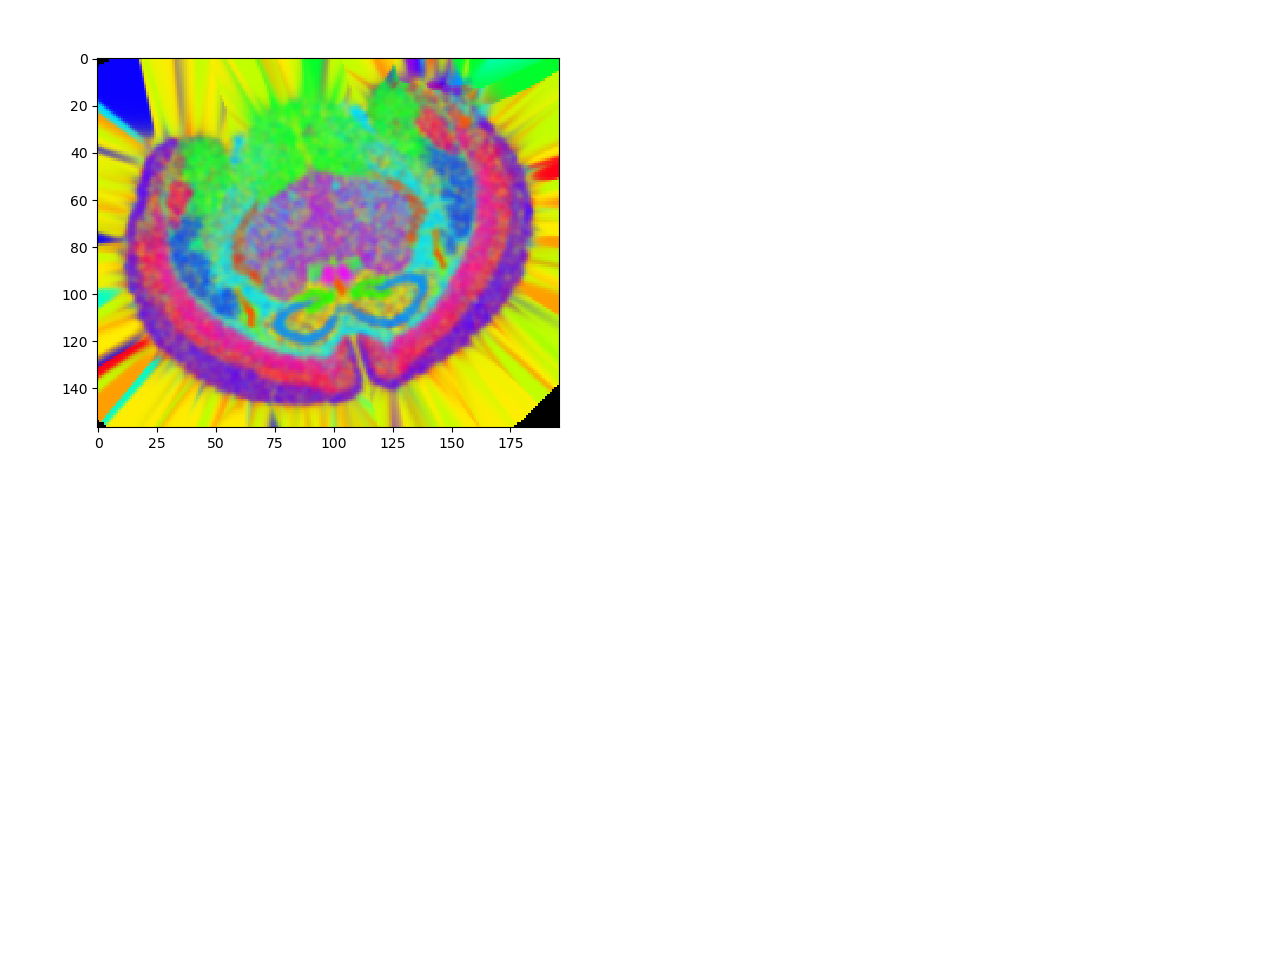

0 of 83546


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


10000 of 83546
20000 of 83546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


30000 of 83546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


40000 of 83546
50000 of 83546
60000 of 83546
70000 of 83546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


80000 of 83546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


83545 of 83546


/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [10]:
f,ax = plt.subplots()
count = 0
for x_,y_,c_ in zip(x,y,c):
    # to speed things up I shoul index
    # to do this I'd have to find row and column indices
    col = np.round((x_ - X_[0])/dx).astype(int)
    row = np.round((y_ - X_[1])/dx).astype(int)
    row0 = np.floor(row-blur*3).astype(int)
    row1 = np.ceil(row+blur*3).astype(int)
    rows = np.arange(row0,row1+1)
    #asdf
    #rows = np.arange(row,row+blur*3+1)
    #rows_ = np.arange(row,row-blur*3-1,-1)
    #rows__ = np.concatenate((rows_[::-1],rows[1:])).astype(int)
    #cols = np.arange(col,col+blur*3+1)
    #cols_ = np.arange(col,col-blur*3-1,-1)
    #cols__ = np.concatenate((cols_[::-1],cols[1:])).astype(int)
    
    ## this step is incrementing one pixel at a time, it is way way faster
    #I[c_,row,col] += 1.0
    #W[row,col] += 1.0
    
    k = np.exp( - ( (X[0] - x_)**2 + (X[1] - y_)**2 )/(2.0*(dx*blur)**2)  )
    k /= np.sum(k)
    I[c_] += k 
    W += k
    
    if not count%10000 or count==(x.shape[0]-1):
        print(f'{count} of {x.shape[0]}')
        Ic = (I.transpose((1,2,0))[:,:,None,:]@colors)[:,:,0,:]/W[...,None]
        ax.cla()
        ax.imshow(Ic)
        f.canvas.draw()
    
    count += 1
Ic = (I.transpose((1,2,0))[:,:,None,:]@colors)[:,:,0,:]/W[...,None]

In [11]:
q = 0.9
Ic = (I.transpose((1,2,0))[:,:,None,:]@colors)[:,:,0,:]/W[...,None]
Ic = np.concatenate((Ic,W[...,None]/np.quantile(W,q)),-1)
f,ax = plt.subplots()
extent = (X_[0],X_[-1],Y_[0],Y_[-1])
h = ax.imshow(Ic,origin='lower', extent=extent,cmap=cmap)
ax.set_title('Mean cell type')
h = plt.colorbar(h)
h.set_ticks(np.arange(C)/C + 1/C/2)
h.ax.set_yticklabels(np.arange(C))
f.savefig('mean_cell_type.png')

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [12]:
P = I/np.sum(I,0,keepdims=True)

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [13]:
G = np.sum(P*(1.0-P),0) # gini impurity
Gc = cm.spring(G)
Gc[...,-1] = W/np.quantile(W,q)
f,ax = plt.subplots()
h = ax.imshow(Gc,origin='lower',extent=extent,cmap='spring',vmin=0,vmax=1)
plt.colorbar(h)
ax.set_title('Gini Impurity')
f.savefig('gini_impurity.png')

<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [14]:
Htosum = -P*np.log(P)/np.log(2) # entropy (bits)
Htosum[np.isnan(Htosum)] = 0.0
H = np.sum(Htosum,0)
vmin = 0.0#np.min(H)
vmax = np.max(H)
Hc = cm.autumn((H-vmin)/(vmax-vmin))
Hc[...,-1] = W/np.quantile(W,q)
f,ax = plt.subplots()
h = ax.imshow(Hc,origin='lower',extent=extent,cmap='autumn',vmin=vmin,vmax=vmax)
plt.colorbar(h)
ax.set_title('Entropy')
f.savefig('entropy.png')

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [15]:
f,ax = plt.subplots()
h = ax.imshow(W,origin='lower',extent=extent)
plt.colorbar(h)
ax.set_title('Cell density')
f.savefig('density.png')

<IPython.core.display.Javascript object>

In [16]:
# start by loading the atlas
import nrrd
imagefile = '/home/dtward/data/AllenInstitute/ara_nissl/ara_nissl_50.nrrd'
vol,hdr = nrrd.read(imagefile)
A = vol
#f,ax = plt.subplots()
#ax.imshow(A[50])

labelfile = '/home/dtward/data/AllenInstitute/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
vol,hdr = nrrd.read(labelfile)
L = vol
#f,ax = plt.subplots()
#ax.imshow(L[50]%7)

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')


In [17]:
f,ax = plt.subplots()
ax.imshow(A[270//2],extent=[xA[2][0],xA[2][-1],xA[1][0],xA[1][-1]])

<IPython.core.display.Javascript object>

In [18]:
A.shape,G.shape

((264, 160, 228), (157, 196))

In [19]:
# when this is done send back a new csv file that has another column that corresponds to allen structure.
# 

In [20]:
# now we will use torch
import torch
from torch.nn.functional import grid_sample
# build an interp function from grid sample
def interp(x,I,phii,**kwargs):
    '''
    Interpolate the image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(3):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done
        
    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,3,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension
    
    return out[0]

In [21]:
dtype = torch.float
device = 'cpu'

I = torch.as_tensor(A[None]/np.mean(np.abs(A)),dtype=dtype,device=device)
J = torch.as_tensor(W[None,None]/np.mean(np.abs(W)),dtype=dtype,device=device)
xI = [torch.as_tensor(x,dtype=dtype,device=device) for x in xA]
xJ = [torch.as_tensor([0.0],device=device,dtype=dtype),
      torch.as_tensor(Y_,device=device,dtype=dtype),
      torch.as_tensor(X_,device=device,dtype=dtype)]
XJ = torch.stack(torch.meshgrid(xJ),-1)

In [22]:
# affine matrix 
L = torch.eye(3,device=device, dtype=dtype, requires_grad=True)
L.data[1,1] = -1
T = torch.zeros(3,device=device,dtype=dtype, requires_grad=True)
T.data[0] = -xI[0][270//2]
T.data[1] = -4000
T.data[2] = 5000
#T.data[2] = 6000 # less good but double checking T

O = torch.tensor([0.,0.,0.,1.],device=device,dtype=dtype)

def to_A(L,T):
    return torch.cat((torch.cat((L,T[:,None]),1),O[None]))

In [23]:
# OR
# we really need a good metric

<IPython.core.display.Javascript object>


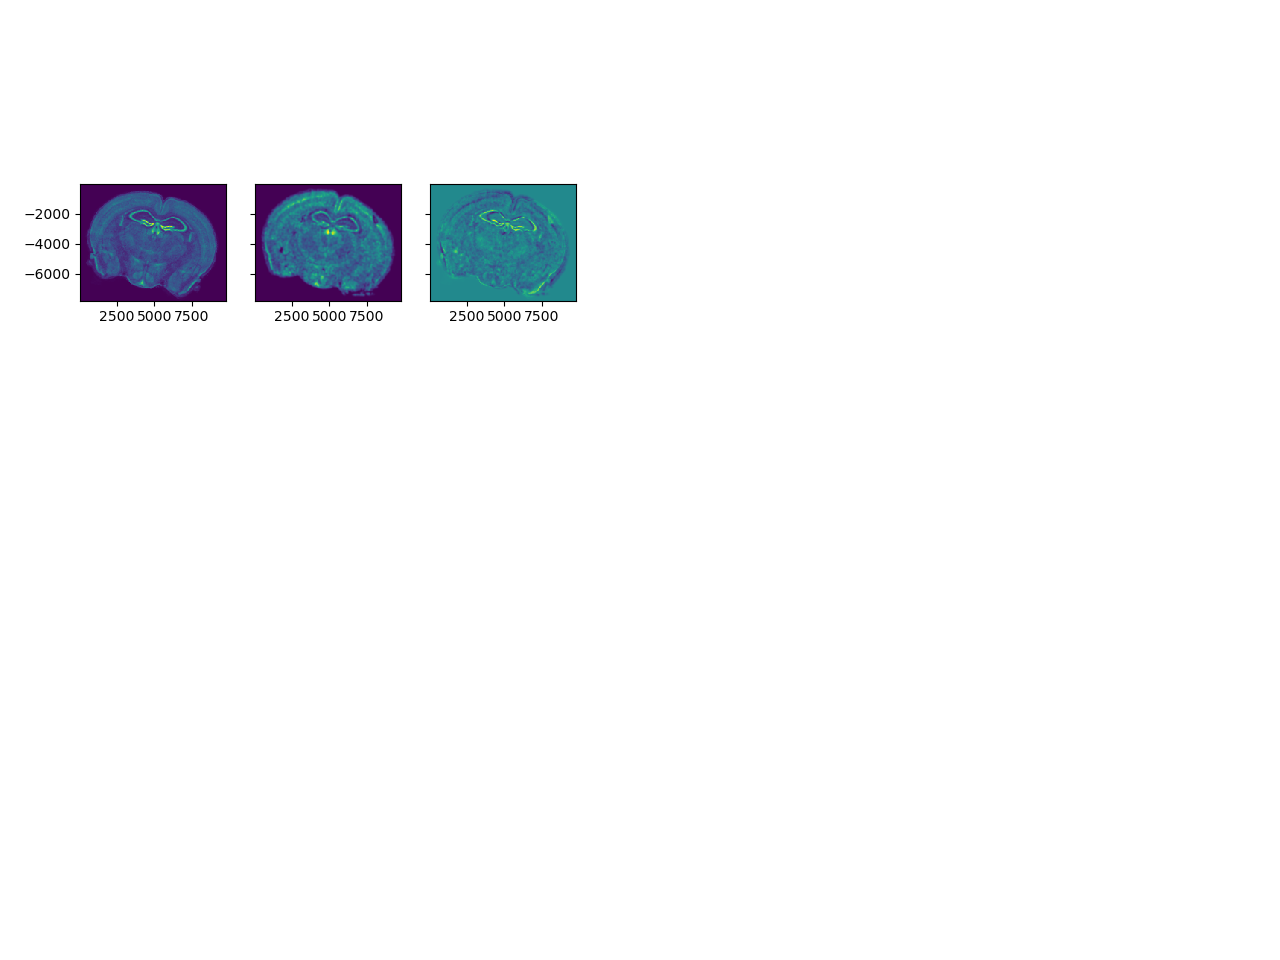

<IPython.core.display.Javascript object>


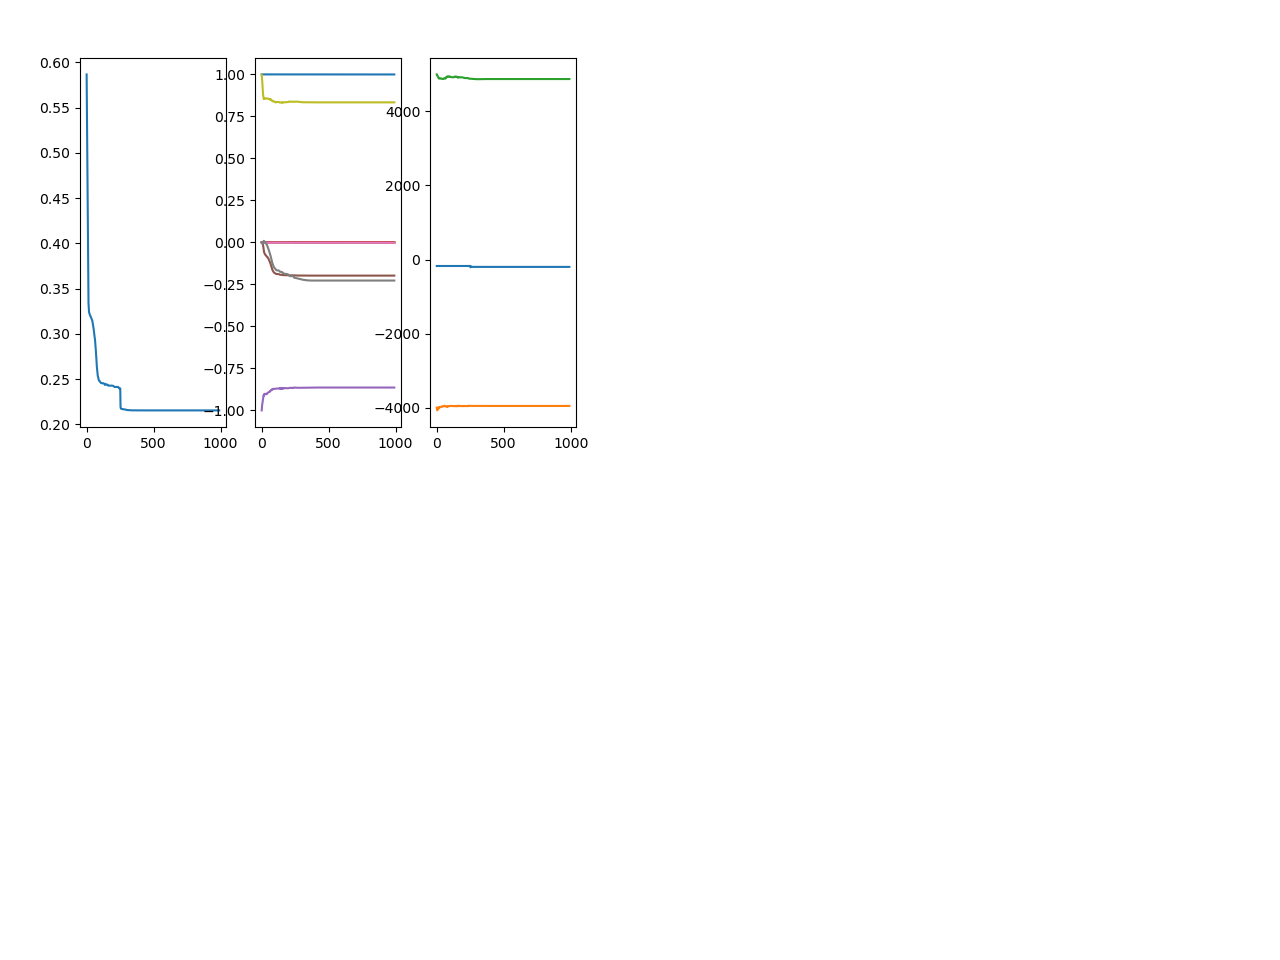

In [24]:
f0,ax0 = plt.subplots(1,3,sharex=True,sharey=True)
f1,ax1 = plt.subplots(1,3)

# optimization
niter = 1000
eL = 1e-2
eT = 1e5

Esave = []
Tsave = []
Lsave = []
for it in range(niter):
    # apply affine transform to atlas
    A = to_A(L,T)
    # invert
    Ai = torch.inverse(A)
    # sample points
    Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
    # transform atlas
    AI = interp(xI,I,Xs.permute(3,0,1,2))
    # contrast
    AI0 = AI - torch.mean(AI)
    if it == 0:
        Jbar = torch.mean(J)
        J0 = J - Jbar
    fAI = AI0 * torch.mean(AI0*J0) / torch.mean(AI0**2) + Jbar
    # cost
    err = fAI-J
    E = torch.mean(err**2)
    E.backward()
    
    Esave.append(E.item())
    Lsave.append(L.detach().clone().cpu().numpy().ravel())
    Tsave.append(T.detach().clone().cpu().numpy().ravel())
    
    # draw
    if not it%10:
        ax0[0].cla()
        ax0[0].imshow(fAI.detach()[0,0].cpu(),extent=extent,origin='lower')
        ax0[1].cla()
        ax0[1].imshow(J.detach()[0,0].cpu(), extent=extent,origin='lower')    
        ax0[2].cla()
        ax0[2].imshow(err.detach()[0,0].cpu(), extent=extent,origin='lower')
        ax1[0].cla()
        ax1[0].plot(Esave)
        ax1[1].cla()
        ax1[1].plot(Lsave)
        ax1[2].cla()
        ax1[2].plot(Tsave)

        f0.canvas.draw()
        f1.canvas.draw()
    # update
    with torch.no_grad():
        if it > 250:
            if it == 251:
                eL /= 5
                eT /= 5
            L -= L.grad*eL
            T -= T.grad*eT
        else:            
            L[1:] -= L.grad[1:]*eL
            T[1:] -= T.grad[1:]*eT
        L.grad.zero_()
        T.grad.zero_()
            
        # TODO
        # use metric?
        # identifiability issues?
        
    

In [25]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
# map the annotations
vol,hdr = nrrd.read(labelfile)
S = torch.as_tensor(vol.astype(float)[None],dtype=dtype,device=device) # note we need float for interp

In [ ]:
AS = torch.round(interp(xI,S,Xs.permute(3,0,1,2),mode='nearest')).int()

In [ ]:
f,ax = plt.subplots()
ax.imshow((AS[0,0]%7).detach().cpu().numpy(),origin='lower',extent=extent)
ax.set_title('Labels')

In [ ]:
len(x),len(y)

In [ ]:
samples = torch.stack([torch.zeros(len(x),device=device,dtype=dtype),torch.as_tensor(y,device=device,dtype=dtype),torch.as_tensor(x,device=device,dtype=dtype)],-1)

In [ ]:
samples.shape

In [ ]:
Xs.shape,samples[None,None].shape

In [ ]:
# assign cells to each label
# I will have to use interpolation
out = interp(xJ,AS.float(),samples[None,None].permute((3,0,1,2)),mode='nearest').int()
# doesnt seem to be working, everything is zeros
# I could also tansform the points and sample directly in atlas space

In [ ]:
col = ((x - X_[0])/dx).astype(int)
row = ((y - Y_[0])/dx).astype(int)
out = AS[0,0,row,col]

In [ ]:
# now we can plot type versus label


In [ ]:
labels = torch.unique(AS).cpu().numpy()
ids = np.arange(len(labels))
mymap = {l:i for l,i in zip(labels,ids)}
counts = torch.zeros((np.max(c)+1,len(labels)))
# we need to map each label to an id
# loop through all the cells
count = 0
for l,c_ in zip(out,c):
    count += 1
    l = l.item()
    counts[c_,mymap[l]] += 1

In [ ]:
f,ax = plt.subplots()
h = ax.imshow(counts,aspect='auto')
plt.colorbar(h)
ax.set_xlabel('Structure ID')
ax.set_ylabel('Cell ID')
ax.set_title('Counts by cell type and structure')
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
counts